In [1]:
import numpy as np # linear algebra
import pandas as pd 
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import time
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.linear_model import *
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer
import matplotlib.pyplot as plt
%matplotlib inline
import re

In [2]:
from sklearn.metrics import mean_squared_log_error
def custom_metric(y_true, y_preds):
    return np.sqrt(mean_squared_log_error(y_true, y_preds))

In [3]:
train = pd.read_csv('/kaggle/input/used-electronics-data/Train.csv')
test = pd.read_csv('/kaggle/input/used-electronics-data/Test.csv')
sample_sub = pd.read_excel('/kaggle/input/used-electronics-data/Sample_Submission.xlsx')

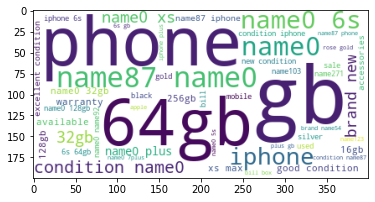

In [4]:
wc = WordCloud(background_color='white',
                    stopwords =  set(STOPWORDS),
                    max_words = 50, 
                    random_state = 42,)
wc.generate(' '.join(train['Model_Info']))
plt.imshow(wc)

In [5]:
df = pd.concat([train, test], axis=0).reset_index(drop=True)

In [6]:
df.head()

,Brand,Model_Info,Additional_Description,Locality,City,State,Price
0,1,name0 name234 64gb space grey,1yesr old mobile number 999two905two99 bill c...,878,8,2,15000.0
1,1,phone 7 name42 name453 new condition box acce...,101004800 1010065900 7000,1081,4,0,18800.0
2,1,name0 x 256gb leess used good condition,1010010000 seperate screen guard 3 back cover...,495,11,4,50000.0
3,1,name0 6s plus 64 gb space grey,without 1010020100 id 1010010300 colour 10100...,287,10,7,16500.0
4,1,phone 7 sealed pack brand new factory outet p...,101008700 10100000 xs max 64 gb made 10100850...,342,4,0,26499.0


In [7]:
df = pd.get_dummies(df, columns = ['Brand', 'City', 'State', 'Locality'])

In [8]:
cvec = TfidfVectorizer(max_features=10000, norm = 'l1', lowercase=True, smooth_idf=False, sublinear_tf=False, ngram_range=(1,4), tokenizer=TreebankWordTokenizer().tokenize)
df_info = pd.DataFrame(cvec.fit_transform(df['Model_Info']).todense())
df_info.columns = ['Model_Info_Top_' + str(c) for c in df_info.columns]
df = pd.concat([df, df_info], axis=1)

In [9]:
def get_gb(x):
    matches = re.findall('[0-9]+(?=\s*gb)', x)
    if len(matches) == 0:
        return np.nan
    else:
        return int(matches[0])
df['gb'] = df['Model_Info'].apply(lambda x: get_gb(x))
df['gb2'] = df['Additional_Description'].apply(lambda x: get_gb(x))

In [10]:
train, test  = df[:train.shape[0]].reset_index(drop=True), df[train.shape[0]:].reset_index(drop=True)

In [11]:
train.columns

Index(['Model_Info', 'Additional_Description', 'Price', 'Brand_0', 'Brand_1',
       'Brand_2', 'Brand_3', 'City_0', 'City_1', 'City_2',
       ...
       'Model_Info_Top_9992', 'Model_Info_Top_9993', 'Model_Info_Top_9994',
       'Model_Info_Top_9995', 'Model_Info_Top_9996', 'Model_Info_Top_9997',
       'Model_Info_Top_9998', 'Model_Info_Top_9999', 'gb', 'gb2'],
      dtype='object', length=11230)

In [12]:
ID_COL, TARGET_COL = 'id', 'Price'
features = [c for c in train.columns if c not in [ID_COL, TARGET_COL, 'Model_Info', 'Additional_Description', 'Locality', 'Brand', 'City', 'State']]
target = train[TARGET_COL]

In [13]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

In [14]:
print(len(features))

11227


In [15]:
training_start_time = time.time()

max_iter = 20
folds = StratifiedKFold(n_splits = max_iter)
oofs = np.zeros(len(train))
test_preds = np.zeros(len(test))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, pd.qcut(target, 10, labels=False, duplicates='drop'))):
    
    print(f'\n---- Fold {fold_} -----\n')
    
    fold_start_time = time.time()
    
    X_trn, y_trn = train.iloc[trn_idx][features], target.iloc[trn_idx]
    X_val, y_val = train.iloc[val_idx][features], target.iloc[val_idx]
    X_test = test[features]
    print(X_trn.shape[1], X_val.shape[1])
    
    
    clf = LGBMRegressor(n_estimators=1000, num_leaves=127, max_depth=-1,min_child_samples=4, learning_rate=0.02, colsample_bytree=0.4, reg_alpha=0.5, reg_lambda=2)
    _ = clf.fit(X_trn, np.log(y_trn), eval_set = [(X_val, np.log(y_val))], verbose=100, early_stopping_rounds=200, eval_metric='rmse')

    oofs[val_idx] = np.exp(clf.predict(X_val))
    current_test_pred = np.exp(clf.predict(X_test))
    test_preds += np.exp(clf.predict(X_test))/max_iter
    
    
    print(f'\n Fold {rmse(np.log(y_val), np.log(oofs[val_idx]))}')
    
    fold_end_time = time.time()
    total_fold_time = int(fold_end_time - fold_start_time)
    
    print(f"\n->-> Fold ran for {(total_fold_time)//60} minutes {(total_fold_time)%60} seconds")
    

print(f'\nOOF val score: {rmse(np.log(target), np.log(oofs))}')
training_end_time = time.time()
total_training_time = int(training_end_time - training_start_time)

print(f'\n->-> Total training time: {(total_training_time)//60} minutes {(total_training_time)%60} seconds')


---- Fold 0 -----

11227 11227
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 0.400465	valid_0's l2: 0.160372
[200]	valid_0's rmse: 0.368424	valid_0's l2: 0.135736
[300]	valid_0's rmse: 0.368634	valid_0's l2: 0.135891
[400]	valid_0's rmse: 0.371005	valid_0's l2: 0.137645
Early stopping, best iteration is:
[238]	valid_0's rmse: 0.36675	valid_0's l2: 0.134505

 Fold 0.36674959710599647

->-> Fold ran for 0 minutes 6 seconds

---- Fold 1 -----

11227 11227
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 0.502611	valid_0's l2: 0.252618
[200]	valid_0's rmse: 0.466942	valid_0's l2: 0.218035
[300]	valid_0's rmse: 0.466458	valid_0's l2: 0.217583
[400]	valid_0's rmse: 0.468607	valid_0's l2: 0.219593
Early stopping, best iteration is:
[273]	valid_0's rmse: 0.465148	valid_0's l2: 0.216363

 Fold 0.4651481042736544

->-> Fold ran for 0 minutes 5 seconds

---- Fold 2 -----

11227 11227
Training until validation scores don't i

In [16]:
print(f'\nOOF val score: {rmse(np.log(target), np.log(oofs))}')


OOF val score: 0.42509485335953884


In [17]:
vp0, tp0 = oofs, test_preds

In [18]:
training_start_time = time.time()

max_iter = 10
folds = StratifiedKFold(n_splits = max_iter)
oofs = np.zeros(len(train))
test_preds = np.zeros(len(test))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, pd.qcut(target, 10, labels=False, duplicates='drop'))):
    
    print(f'\n---- Fold {fold_} -----\n')
    
    fold_start_time = time.time()
    
    X_trn, y_trn = train.iloc[trn_idx][features], target.iloc[trn_idx]
    X_val, y_val = train.iloc[val_idx][features], target.iloc[val_idx]
    X_test = test[features]
    print(X_trn.shape[1], X_val.shape[1])
    

    clf = XGBRegressor(n_estimators=1000, max_depth=12, learning_rate=0.05, colsample_bytree=0.45)
    _ = clf.fit(X_trn, np.log(y_trn), eval_set = [(X_val, np.log(y_val))], verbose=100, early_stopping_rounds=200, eval_metric='rmse')
    

    oofs[val_idx] = np.exp(clf.predict(X_val))
    current_test_pred = np.exp(clf.predict(X_test))
    test_preds += np.exp(clf.predict(X_test))/max_iter
    
    
    print(f'\n Fold {rmse(np.log(y_val), np.log(oofs[val_idx]))}')
    
    fold_end_time = time.time()
    total_fold_time = int(fold_end_time - fold_start_time)
    
    print(f"\n->-> Fold ran for {(total_fold_time)//60} minutes {(total_fold_time)%60} seconds")
    

print(f'\nOOF val score: {rmse(np.log(target), np.log(oofs))}')
training_end_time = time.time()
total_training_time = int(training_end_time - training_start_time)

print(f'\n->-> Total training time: {(total_training_time)//60} minutes {(total_training_time)%60} seconds')


---- Fold 0 -----

11227 11227
[0]	validation_0-rmse:8.91302
Will train until validation_0-rmse hasn't improved in 200 rounds.
[100]	validation_0-rmse:0.43136
[200]	validation_0-rmse:0.42747
[300]	validation_0-rmse:0.42524
[400]	validation_0-rmse:0.42438
[500]	validation_0-rmse:0.42525
Stopping. Best iteration:
[370]	validation_0-rmse:0.42347


 Fold 0.42346924932591967

->-> Fold ran for 3 minutes 56 seconds

---- Fold 1 -----

11227 11227
[0]	validation_0-rmse:8.89285
Will train until validation_0-rmse hasn't improved in 200 rounds.
[100]	validation_0-rmse:0.44585
[200]	validation_0-rmse:0.44360
[300]	validation_0-rmse:0.44173
[400]	validation_0-rmse:0.44117
[500]	validation_0-rmse:0.44112
[600]	validation_0-rmse:0.44108
[700]	validation_0-rmse:0.44106
[800]	validation_0-rmse:0.44083
[900]	validation_0-rmse:0.44017
[999]	validation_0-rmse:0.43999

 Fold 0.43990983068339895

->-> Fold ran for 6 minutes 18 seconds

---- Fold 2 -----

11227 11227
[0]	validation_0-rmse:8.87175
Will trai

In [19]:
vp1, tp1 = oofs, test_preds

In [20]:
# tp1

In [21]:
training_start_time = time.time()

max_iter = 10
folds = StratifiedKFold(n_splits = max_iter)
oofs = np.zeros(len(train))
test_preds = np.zeros(len(test))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, pd.qcut(target, 10, labels=False, duplicates='drop'))):
    
    print(f'\n---- Fold {fold_} -----\n')
    
    fold_start_time = time.time()
    
    X_trn, y_trn = train.iloc[trn_idx][features], target.iloc[trn_idx]
    X_val, y_val = train.iloc[val_idx][features], target.iloc[val_idx]
    X_test = test[features]
    print(X_trn.shape[1], X_val.shape[1])
    
    
    
    clf = CatBoostRegressor(n_estimators=2000, learning_rate=0.05, max_depth=9, rsm=0.5)
    _ = clf.fit(X_trn, np.log(y_trn), eval_set = [(X_val, np.log(y_val))], verbose=100, early_stopping_rounds=200)

    oofs[val_idx] = np.exp(clf.predict(X_val))
    current_test_pred = np.exp(clf.predict(X_test))
    test_preds += np.exp(clf.predict(X_test))/max_iter
    
    
    
    print(f'\n Fold {rmse(np.log(y_val), np.log(oofs[val_idx]))}')
    
    fold_end_time = time.time()
    total_fold_time = int(fold_end_time - fold_start_time)
    
    print(f"\n->-> Fold ran for {(total_fold_time)//60} minutes {(total_fold_time)%60} seconds")
    

print(f'\nOOF val score: {rmse(np.log(target), np.log(oofs))}')
training_end_time = time.time()
total_training_time = int(training_end_time - training_start_time)

print(f'\n->-> Total training time: {(total_training_time)//60} minutes {(total_training_time)%60} seconds')


---- Fold 0 -----

11227 11227
0:	learn: 0.8223909	test: 0.7983530	best: 0.7983530 (0)	total: 224ms	remaining: 7m 28s
100:	learn: 0.4664084	test: 0.4909600	best: 0.4909360 (99)	total: 12.8s	remaining: 4m
200:	learn: 0.3999007	test: 0.4616260	best: 0.4616260 (200)	total: 25.8s	remaining: 3m 50s
300:	learn: 0.3495631	test: 0.4466334	best: 0.4466334 (300)	total: 39.1s	remaining: 3m 40s
400:	learn: 0.3182564	test: 0.4422385	best: 0.4421309 (382)	total: 51.8s	remaining: 3m 26s
500:	learn: 0.2900792	test: 0.4381738	best: 0.4381738 (500)	total: 1m 4s	remaining: 3m 13s
600:	learn: 0.2689368	test: 0.4369230	best: 0.4368710 (565)	total: 1m 17s	remaining: 3m
700:	learn: 0.2497412	test: 0.4360137	best: 0.4357959 (694)	total: 1m 30s	remaining: 2m 47s
800:	learn: 0.2344139	test: 0.4344313	best: 0.4343043 (795)	total: 1m 43s	remaining: 2m 34s
900:	learn: 0.2206543	test: 0.4338882	best: 0.4338882 (900)	total: 1m 55s	remaining: 2m 21s
1000:	learn: 0.2098987	test: 0.4326616	best: 0.4326592 (996)	total:

In [22]:
vp2, tp2 = oofs, test_preds

In [23]:
np.corrcoef(tp1, tp2)

array([[1.       , 0.9852083],
       [0.9852083, 1.       ]])

In [24]:
test_preds = tp0*0.3 + tp1*0.4 + tp2*0.3

In [25]:
print(f'\nOOF val score: {rmse(np.log(target), np.log(oofs))}')


OOF val score: 0.4329408220444261


In [26]:
print(f'\nOOF val score: {rmse(np.log(target), np.log(vp0*0.3 + vp1*0.4 + vp2*0.3))}')


OOF val score: 0.42141066134447913


In [27]:
sub = pd.DataFrame({'Price': test_preds})
sub['Price'] = np.clip(sub['Price'], target.min(), target.max())
sub['Price'].describe()

count       997.000000
mean      23746.362804
std       17906.136170
min        2994.720877
25%       12755.126234
50%       18223.154471
75%       27780.075220
max      115508.032103
Name: Price, dtype: float64

In [28]:
sub.head(10)

,Price
0,14467.069091
1,7961.803401
2,13981.501719
3,46472.021104
4,6526.759492
5,27036.454688
6,18944.846661
7,12050.418292
8,14074.376350
9,15000.094393


In [29]:
SUB_FILE_NAME = 'used_price_v18.xlsx'
sub.to_excel(SUB_FILE_NAME, index=False)

In [30]:
from IPython.display import HTML
def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)
create_download_link(filename = SUB_FILE_NAME)